# Distracted Driving Detection

## Colab Link
https://colab.research.google.com/drive/1JgyBsLZ9AjC9TSHJy-Bfm932MblCzQJJ?usp=sharing


In [8]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
torch.manual_seed(1000) # set the random seed

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path  = '/content/drive/MyDrive/APS 360 - Team 34/Dataset/state-farm-distracted-driver-detection/train_original/Relevant Set'
test_path = '/content/drive/My Drive/APS 360 - Team 34/Dataset/Testing Dataset'

# Data Loader 

In [10]:
# Adding Noise 
'''
noise = 0.5
img_noisy = img + noise * torch.randn(*img.shape)
img_noisy = np.clip(img_noisy, 0., 1.)
'''
class AddNoise(object):
    def __init__(self, noise = 0.5):
        self.noise = noise
        
    def __call__(self, tensor):
        tensor_noisy = tensor + self.noise * torch.randn(*tensor.shape)
        return np.clip (tensor_noisy,0., 1.)
        #return tensor_noisy
    
    def __repr__(self):
        return self.__class__.__name__ + '(noise={0}})'.format(self.noise)

In [11]:
def get_data_loader(batch_size=1, size = 224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """ Loads images of hand gestures, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
    """

    ########################################################################
    # Transform the image
  
    transform = transforms.Compose(
        [transforms.Resize((size, size)),
        transforms.ToTensor(),
         transforms.RandomApply([AddNoise()], p = 0.3),
         transforms.Normalize(mean = mean, std=std)
         ])
    
    transform_tst = transforms.Compose(
        [transforms.Resize((size, size)),
        transforms.ToTensor(),
         transforms.Normalize(mean = mean, std=std)]
         )
    # Load ImageFolder dataset
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_tst)
          
    # Get the list of indices to sample from
    indices = list(range(len(dataset)))
    # Split into train, test and validation
    np.random.seed(1) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)
    split_train = int(len(indices) * 0.8) #split at 80%
    split_val = int(split_train + len(indices) * 0.2) #split from 81-100%
    
    # split into training, validation and testing indices
    train_indices = indices[:split_train]
    val_indices = indices[split_train:]  
 
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=1)
    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
'''mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]'''

'mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]'

In [ ]:
print(len(train_loader.dataset.imgs))
print(len(train_loader) * 5)

20475
81900


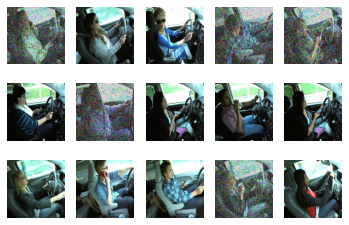

In [ ]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

# AlexNet Pre Trained Features

In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)

import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features'

# Prepare Dataloader (requires code from 1.)
batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader, val_loader, test_loader = get_data_loader()

classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8']

# save features to folder as tensors
def save_features_folder(data_loader):
  n = 0
  for img, label in data_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = master_path + '/' + str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
#DO NOT RUN THIS CODE
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Multi-Class Features/Training_Features'
save_features_folder(train_loader)
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Multi-Class Features/Validation_Features'
save_features_folder(val_loader)

In [ ]:
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'
save_features_folder(test_loader)

In [12]:
# Load Tensor Files (features) from folder

#load features
# location on Google Drive
def load_features(batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))

  # Prepare Dataloader
  num_workers = 1
  feature_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  # Verification Step - obtain one batch of features
  dataiter = iter(feature_loader)
  features, labels = dataiter.next()
  print(features.shape)
  print(labels.shape)

  return feature_loader

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Multi-Class Features/Training_Features'
feature_train = load_features()

master_path = '/content/drive/MyDrive/APS 360 - Team 34/Multi-Class Features/Validation_Features'
feature_val = load_features()

torch.Size([32, 256, 6, 6])
torch.Size([32])
torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
master_path = '/content/drive/MyDrive/APS 360 - Team 34/Features/Test_Features'
feature_test = load_features()

# Model

In [13]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "/content/drive/MyDrive/APS 360 - Team 34/model_results/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        predic = outputs.max(1, keepdim=True)[1]
        corr   = predic.eq(labels.view_as(predic))
        total_err += len(labels) - corr.sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
    err = (float(total_err) / total_epoch)
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    if overfit == False:
      plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    if overfit == False:
      plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [14]:
class TrasfLearnNet(nn.Module):
    def __init__(self, fc_no_layer = 1, hidden_units1 = 12, hidden_units2 = 5, kernel_size = 3, out_channel1 = 10, name = "AlexNet"):
        super(TrasfLearnNet, self).__init__()
        self.name = name
        self.conv1 = nn.Conv2d(256, out_channel1, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.hidden_units1 = hidden_units1
        self.hidden_units2 = hidden_units2
        self.kernel_size = kernel_size
        self.out_channel1 = out_channel1
        self.fc_no_layer = fc_no_layer
        if fc_no_layer == 1:
            self.fc1 = nn.Linear(out_channel1 * 2 * 2, 9)
        elif fc_no_layer == 2:
            self.fc1 = nn.Linear(out_channel1 * 2 * 2, hidden_units2)
            self.fc2 = nn.Linear(hidden_units2, 9)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10 * 2 * 2)
        if self.fc_no_layer == 1:
            x = self.fc1(x)
        elif fc_no_layer == 2:
            x = self.fc1(x)
            x = self.fc2(F.relu(x))
        return x

In [15]:
def train_net(net, batch_size=1, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets

    train_loader, val_loader = feature_train, feature_val
  
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            #labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            predic = outputs.max(1, keepdim=True)[1]
            corr   = predic.eq(labels.view_as(predic))
            total_train_err += len(labels) - corr.sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = (torch.true_divide(float(total_train_err), total_epoch))
        train_loss[epoch] = torch.true_divide(float(total_train_loss), (i+1))
        
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        '''print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))'''
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')

    if overfit == False:
      print(("Minimum Val Error Epoch: {}, Minimum Val loss Epoch: {}|"+
              "Validation err: {}, Validation loss: {}|"+
            "Training Error: {}, Training loss: {}").format(
                  np.argmin(val_err),
                  np.argmin(val_loss),
                  min(val_err),
                  min(val_loss),
                  train_err[np.argmin(val_err)],
                  train_loss[np.argmin(val_loss)]))

    print(("Validation err: {}, Validation loss: {}|"+
           "Training Error: {}, Training loss: {}").format(
                val_err[num_epochs-1],
                val_loss[num_epochs-1],
                train_err[num_epochs-1],
                train_loss[num_epochs-1]))
    
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Training

In [37]:
use_cuda = False
name = "AlexNet1"
overfit = False
output = TrasfLearnNet(name = name)


if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=32, learning_rate=0.001, num_epochs=30)

Finished Training
Minimum Val Error Epoch: 5, Minimum Val loss Epoch: 5|Validation err: 0.15653235653235653, Validation loss: 0.4718684969120659|Training Error: 0.13571429252624512, Training loss: 0.3881855607032776
Validation err: 0.1619047619047619, Validation loss: 0.6150538135552779|Training Error: 0.06813187152147293, Training loss: 0.19358418881893158


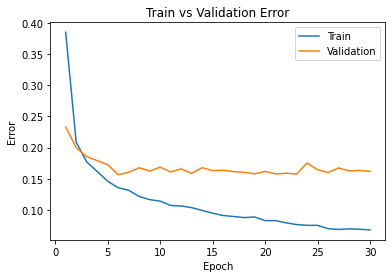

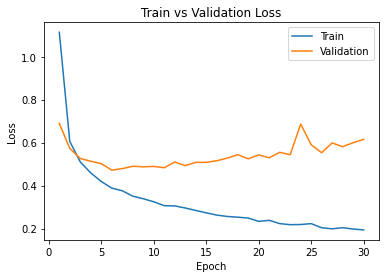

In [38]:
model_path = get_model_name(output.name, batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [19]:
output = TrasfLearnNet(name = "Initial_add_noise")
overfit = False

In [40]:
isAlexNet = True
use_cuda = False
output = TrasfLearnNet(name = "Initial_add_noise")
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=30)

Finished Training
Minimum Val Error Epoch: 5, Minimum Val loss Epoch: 5|Validation err: 0.15653235653235653, Validation loss: 0.4718684969120659|Training Error: 0.13571429252624512, Training loss: 0.3881855607032776
Validation err: 0.1619047619047619, Validation loss: 0.6150538135552779|Training Error: 0.06813187152147293, Training loss: 0.19358418881893158


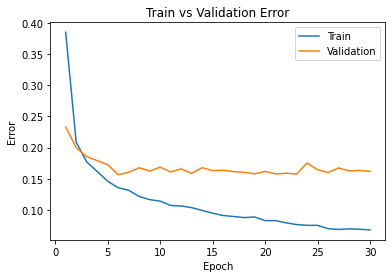

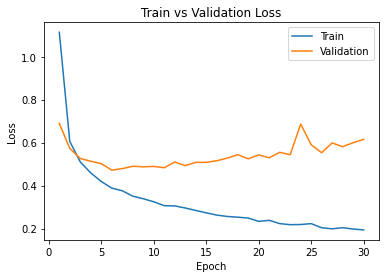

In [20]:
model_path = get_model_name(output.name, batch_size=2, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = True
output = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=50)

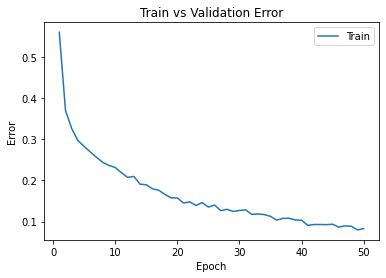

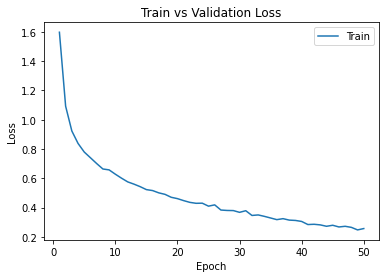

In [ ]:
model_path = get_model_name(output.name, batch_size=2, learning_rate=0.001, epoch=49)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = True
output = TrasfLearnNet()
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=100)

Finished Training
Validation err: 0.0, Validation loss: 0.0|Training Error: 0.01315789483487606, Training loss: 0.06602846831083298


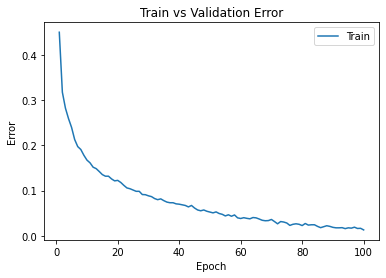

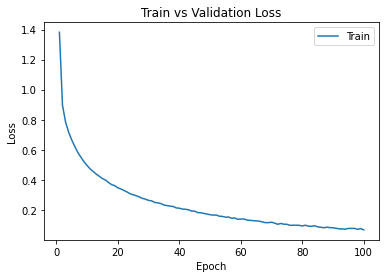

In [ ]:
model_path = get_model_name(output.name, batch_size=2, learning_rate=0.001, epoch=99)
plot_training_curve(model_path)

In [ ]:
isAlexNet = True
use_cuda = True
overfit = False
output = TrasfLearnNet(name = "Initial_add_noise")
if use_cuda and torch.cuda.is_available():
    output = output.cuda()
train_net(output, batch_size=2, learning_rate=0.001, num_epochs=30)

Finished Training
Minimum Val Error Epoch: 11, Minimum Val loss Epoch: 9|Validation err: 0.1690340909090909, Validation loss: 0.5157111192291434|Training Error: 0.0810810774564743, Training loss: 0.28586262464523315
Validation err: 0.1846590909090909, Validation loss: 0.7110052633691918|Training Error: 0.009601706638932228, Training loss: 0.06507275253534317


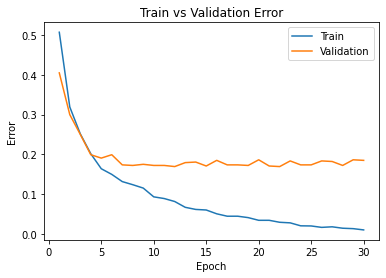

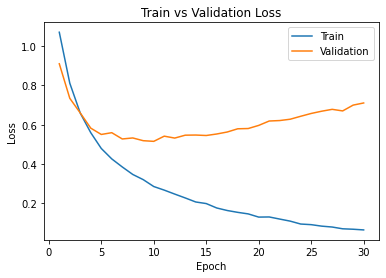

In [ ]:
model_path = get_model_name("Initial_add_noise", batch_size=2, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [ ]:
model_path = get_model_name("Initial_add_noise", batch_size=2, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

# Baseline Model: SVM

In [ ]:
train_loader, val_loader, test_loader = get_data_loader()

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

2812
704
1167


In [ ]:
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
training_data = []
training_labels = []
i=0
noise = 0.5

for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    
    training_data.append((images[0].detach().numpy().flatten()))
    labelnp = labels[0]
    training_labels.append(labelnp.item())
    # Adding Noise 
    img_noisy = images + noise * torch.randn(*images.shape)
    img_noisy = np.clip(img_noisy, 0., 1.)
    training_data.append((img_noisy[0].detach().numpy().flatten()))
    training_labels.append(labelnp.item())
    i+=1



In [ ]:
i=0
testing_data = []
testing_labels = []
noise = 0.5

for images, labels in test_loader:
    # since batch_size = 1, there is only 1 image in `images`
    testing_data.append(images[0].detach().numpy().flatten())

    labelnp = labels[0]
    testing_labels.append(labelnp.item())
    #add noise
    '''img_noisy = images + noise * torch.randn(*images.shape)
    img_noisy = np.clip(img_noisy, 0., 1.)
    training_data.append((img_noisy[0].detach().numpy().flatten()))
    testing_labels.append(labelnp.item())'''

    i+=1


In [ ]:
#print(testing_data[0].shape)
print(training_labels[0].shape)
print(training_data)
print(training_labels)

In [ ]:
from sklearn import svm
model = svm.SVC(gamma=2, C=1)

#train_loader, val_loader, test_loader = get_data_loader():

# Fit the model to our training data
model.fit(training_data, training_labels)

# Make predictions
testing_predicted = model.predict(testing_data)
score = 100*(1-sum(abs(testing_predicted-testing_labels))/len(testing_predicted))
print("SVM Test:", score)

SVM Test: 21.765209940017137


In [ ]:
training_predicted = model.predict(training_data)
score_train = 100*(1-sum(abs(training_predicted-training_labels))/len(training_predicted))
print("SVM Train:", score_train)

SVM Train: 99.67994310099573


In [ ]:
from sklearn import svm
model = svm.SVC(gamma=2, C=1)

#train_loader, val_loader, test_loader = get_data_loader():

# Fit the model to our training data
model.fit(training_data, training_labels)

# Make predictions
testing_predicted = model.predict(testing_data)
score = 100*(1-sum(abs(testing_predicted-testing_labels))/len(testing_predicted))
print("SVM Test:", score)

In [ ]:
training_predicted = model.predict(training_data)
score_train = 100*(1-sum(abs(training_predicted-training_labels))/len(training_predicted))
print("SVM Train:", score_train)